In [ ]:
!pip install tensorflow_text

     |████████████████████████████████| 4.9 MB 5.1 MB/s 


In [ ]:
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import numpy as np

In [ ]:
data = pd.read_csv("all_translated_data.csv", encoding = "utf-8")
print(data.language.value_counts())

bn    1093
ml    1025
hi    1000
en    1000
ta     948
Name: language, dtype: int64


In [ ]:
data = data.loc[(data.language == "bn")]
data.head()

,Unnamed: 0,text,language,majority_label,source,annotator1,annotator2,annotator3,translated_texts
1025,1025,সার্জিক্যাল স্ট্রাইকের কৃতিত্ব যদি সরকার নিতে ...,bn,Yes,social media,Yes,Yes,No,If the government is able to take control of t...
1026,1026,*www.bahrswb.org: বিজেপির ‘জয় শ্রীরাম’ নিয়ে এ ...,bn,Yes,social media,Yes,Yes,Probably,*www.bahrswb.org: Bizzupir's chief minister of...
1027,1027,তোমার জন্য স্পেশাল কিছু পাঠিয়েছি তাড়াতাড়ি ন...,bn,No,social media,No,No,No,I sent you something special and quickly click...
1028,1028,*ইটামগরা ২নং অঞ্চল তৃণমূল কংগ্রেসের ডাকে সর্ব ...,bn,No Majority,social media,No,Yes,Probably,*The election meeting in support of the presid...
1029,1029,"ইষ্টের আসনে অন্য কোন ফটো রাখলে ক্ষতি কি ?. ""আ...",bn,No,social media,No,No,No,What's wrong with keeping any other photos in ...


In [ ]:
data["claim"] = data["majority_label"].apply(lambda x: 1 if x == "Yes" else (0 if x == "No" else "No_Majority"))
# Just use the texts with a majority label
data = data[data.claim != "No_Majority"]
data = data.reset_index(drop=True)
data.head()

,Unnamed: 0,text,language,majority_label,source,annotator1,annotator2,annotator3,translated_texts,claim
0,1025,সার্জিক্যাল স্ট্রাইকের কৃতিত্ব যদি সরকার নিতে ...,bn,Yes,social media,Yes,Yes,No,If the government is able to take control of t...,1
1,1026,*www.bahrswb.org: বিজেপির ‘জয় শ্রীরাম’ নিয়ে এ ...,bn,Yes,social media,Yes,Yes,Probably,*www.bahrswb.org: Bizzupir's chief minister of...,1
2,1027,তোমার জন্য স্পেশাল কিছু পাঠিয়েছি তাড়াতাড়ি ন...,bn,No,social media,No,No,No,I sent you something special and quickly click...,0
3,1029,"ইষ্টের আসনে অন্য কোন ফটো রাখলে ক্ষতি কি ?. ""আ...",bn,No,social media,No,No,No,What's wrong with keeping any other photos in ...,0
4,1030,"আসন্ন সপ্তদশ লোকসভা নির্বাচনে , কাঁথি লোকসভা ক...",bn,Yes,social media,No,Yes,Yes,At the next seventeenth People's Assembly elec...,1


In [ ]:
len(data)

922

In [ ]:
#data = data[["text", "claim"]]
#data.head()

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data["text"], data["claim"], stratify = data["claim"],test_size=0.10, random_state=1)

print('train shape: ',X_train.shape)
print('test shape: ',X_test.shape)
print(len(X_train))
print(y_train)
print(y_train.value_counts())

train shape:  (829,)
test shape:  (93,)
829
177    1
814    0
320    1
231    0
473    0
      ..
434    0
16     0
612    0
61     1
276    1
Name: claim, Length: 829, dtype: object
0    533
1    296
Name: claim, dtype: int64


In [ ]:
# Bert-en-uncased:
#bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
#bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

# Distillbert-en-uncased:
#bert_preprocess = hub.KerasLayer("https://tfhub.dev/jeongukjae/distilbert_en_uncased_preprocess/2")
#bert_encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/distilbert_en_uncased_L-6_H-768_A-12/1")

# MuRil Model:
#bert_preprocess = hub.KerasLayer("https://tfhub.dev/google/MuRIL_preprocess/1")
#bert_encoder = hub.KerasLayer("https://tfhub.dev/google/MuRIL/1")

# Bert-Multi-Model (https://github.com/google-research/bert/blob/master/multilingual.md):
#bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3")
#bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/4")

# DistillBert-Multi-Model (https://github.com/google-research/bert/blob/master/multilingual.md):
bert_preprocess = hub.KerasLayer("https://tfhub.dev/jeongukjae/distilbert_multi_cased_preprocess/2")
bert_encoder = hub.KerasLayer("https://tfhub.dev/jeongukjae/distilbert_multi_cased_L-6_H-768_A-12/1")

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
y_train=np.asarray(y_train).astype(np.int)
len(y_train)

829

In [ ]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
26/26 [==============================] - 183s 7s/step - loss: 0.6653 - accuracy: 0.6236 - precision: 0.3400 - recall: 0.0574
Epoch 2/10
26/26 [==============================] - 177s 7s/step - loss: 0.6207 - accuracy: 0.6598 - precision: 0.7059 - recall: 0.0811
Epoch 3/10
26/26 [==============================] - 176s 7s/step - loss: 0.6040 - accuracy: 0.6598 - precision: 0.6842 - recall: 0.0878
Epoch 4/10
26/26 [==============================] - 176s 7s/step - loss: 0.5789 - accuracy: 0.7262 - precision: 0.7143 - recall: 0.3885
Epoch 5/10
26/26 [==============================] - 175s 7s/step - loss: 0.5687 - accuracy: 0.7129 - precision: 0.7788 - recall: 0.2736
Epoch 6/10
26/26 [==============================] - 181s 7s/step - loss: 0.5607 - accuracy: 0.7250 - precision: 0.7179 - recall: 0.3784
Epoch 7/10
26/26 [==============================] - 178s 7s/step - loss: 0.5508 - accuracy: 0.7226 - precision: 0.7426 - recall: 0.3412
Epoch 8/10
26/26 [==============================

In [ ]:
import numpy as np
y_test=np.asarray(y_test).astype(np.int)
y_test

array([1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 0, 0])

In [ ]:
model.evaluate(X_test, y_test)

3/3 [==============================] - 22s 7s/step - loss: 0.5670 - accuracy: 0.7312 - precision: 0.6818 - recall: 0.4545


[0.5669814348220825,
 0.7311828136444092,
 0.6818181872367859,
 0.4545454680919647]

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:
import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0])

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[53,  7],
       [18, 15]])

In [ ]:
from sklearn.metrics import classification_report

Text(33.0, 0.5, 'Truth')

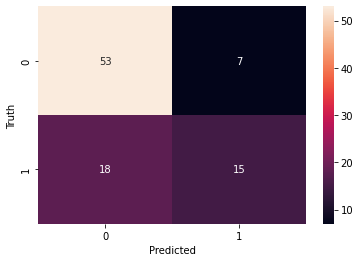

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.75      0.88      0.81        60
           1       0.68      0.45      0.55        33

    accuracy                           0.73        93
   macro avg       0.71      0.67      0.68        93
weighted avg       0.72      0.73      0.72        93

